For XGBoost model before and after ReducedOverfitting.

The RMSE and Weighted RMSE estimation per bins for dataset where damaged values are greater than 10.

In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib

wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")
#display(combined_input_data)

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 


combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        #'GEN_Bu_p_inSSA', 
        #'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        #'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        #'TOP_mean_ruggedness',
        #'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']


df=combined_input_data.dropna()
display(df)





,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
2,durian2006,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.00,...,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000
4,durian2006,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,1.28,...,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000
6,durian2006,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,...,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000
7,durian2006,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.36,...,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,noul2015,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,6.25,...,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000
25837,noul2015,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,...,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000
25838,noul2015,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.09,...,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000
25839,noul2015,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,...,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000


In [2]:
df = df[df['DAM_perc_dmg'] > 10]
df

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
39,durian2006,128.785714,7.623810,4.991964,67.297247,304783.811133,16.034037,0.61,0.00,0.00,...,0.027878,13.639532,25.425146,0.069696,0.000000,0.006970,0.006970,2.458422,28.331475,39.364371
40,durian2006,137.600000,10.846970,5.338258,54.729980,163936.581742,14.053818,2.58,7.27,7.27,...,0.072745,2.982541,24.709020,0.072745,0.048497,0.181862,0.218235,2.364638,40.058196,16.585839
67,durian2006,236.800000,23.022917,9.250000,68.469676,320992.456376,28.294582,5.76,1.26,1.26,...,0.250179,5.611151,31.486776,0.321658,0.035740,0.071480,0.178699,3.152242,31.665475,47.140815
79,durian2006,166.710000,11.723333,6.353750,64.000391,262148.800838,20.452986,0.97,0.03,0.03,...,0.010288,9.526749,40.843621,0.041152,0.020576,0.000000,0.010288,2.276694,30.884774,50.154321
80,durian2006,218.475000,20.925000,8.506771,76.858109,454013.837540,16.963048,6.14,2.50,2.50,...,0.420633,4.250609,19.216294,0.420633,0.066416,0.088554,0.221386,1.762301,22.647775,51.073721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23423,vongfong2020,254.525000,23.410417,9.786458,47.579864,107713.362477,0.993916,0.00,0.00,0.00,...,0.348635,0.232423,39.628123,0.232423,0.000000,0.116212,0.058106,2.409639,44.973852,18.651947
23461,vongfong2020,255.687500,21.612500,9.660417,48.218915,112112.054833,7.514910,0.00,0.00,0.00,...,0.121556,4.821718,51.782820,0.526742,0.000000,0.121556,0.283630,7.043011,27.350081,74.230146
23877,vongfong2020,258.160000,18.825000,9.100833,49.041771,117950.133023,0.746003,0.00,0.00,0.00,...,0.980693,2.666258,38.768005,0.796813,0.122587,0.367760,0.337113,4.078437,34.293595,27.244867
23958,vongfong2020,212.800000,15.002381,7.574107,43.430665,81919.906658,1.708735,0.00,0.00,0.00,...,0.000000,0.880734,54.311927,0.183486,0.000000,0.073394,0.293578,5.823910,39.559633,16.183486


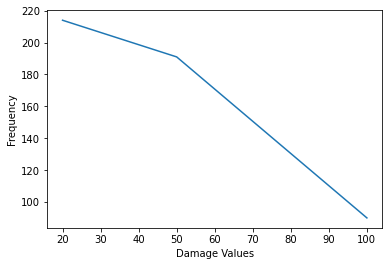

In [3]:
#The Second chosen bins
bins2= [10.0009, 20, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [4]:
print(samples_per_bin2)
print(binsP2)

[214 191  90]
[ 10.0009  20.      50.     100.    ]


In [5]:
df['DAM_perc_dmg'].value_counts(bins=binsP2)

(10.0, 20.0]     214
(20.0, 50.0]     191
(50.0, 100.0]     90
Name: DAM_perc_dmg, dtype: int64

In [6]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [7]:
y_input_strat=bin_index2

In [8]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 03:00:06


In [9]:
#Define empty lists for bins results(test)
test_RMSE_list_bin1=[]
test_RMSE_list_bin2=[]
test_RMSE_list_bin3=[]


#Define empty lists for bins results(train)
train_RMSE_list_bin1=[]
train_RMSE_list_bin2=[]
train_RMSE_list_bin3=[]


In [10]:
from sklearn import preprocessing
import statsmodels.api as sm
import statistics
# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

def func(x):
    return np.log(x+1)+1

for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    
    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)
    
    #With Solving Overfitting
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                       colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                       importance_type='gain', learning_rate=0.1, max_delta_step=0,
                       max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"]
                      )

    
    eval_set = [(X_test, y_test)]
    xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False, sample_weight=y_train
    #                  #sample_weight=np.log(y_train+1)+1
                     )   
    
    #Without Solving Overfitting
    #xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
    #xgb_model=xgb.fit(X_train, y_train, sample_weight=y_train
    #                  #sample_weight=np.log(y_train+1)+1
    #                 )
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    y_pred_train = xgb.predict(X_train)
    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    

    y_pred = xgb.predict(X_test)
    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    rmse_3 = np.sqrt(mse_idx3)

    
    
    print('----- Training_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')

    
    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
    
    
    print('----- Test_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_3:.2f}')

    
    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3)
   
    

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     8.276
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           6.77e-27
Time:                        03:00:35   Log-Likelihood:                -1668.9
No. Observations:                 396   AIC:                             3402.
Df Residuals:                     364   BIC:                             3529.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.8470      0.868     35.521      0.0

In [11]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-10-20 03:00:43


stdev_RMSE_test: 1.70
stdev_RMSE_train: 1.00
mean_RMSE_test: 18.92
mean_RMSE_train: 13.51


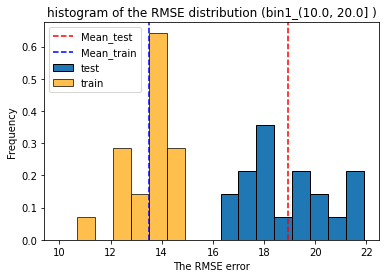

In [12]:
#RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin1, bins=np.arange(10.0,22.0,0.7), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin1, bins=np.arange(10.0,22.0,0.7), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(0.8,2.9,0.12)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin1_(10.0, 20.0] )')
plt.show()

stdev_RMSE_test: 1.21
stdev_RMSE_train: 0.34
mean_RMSE_test: 12.72
mean_RMSE_train: 7.20


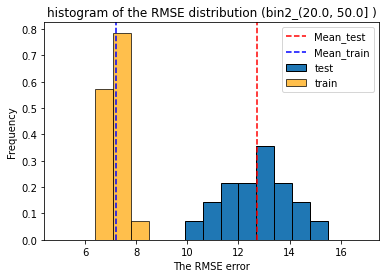

In [13]:
#RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin2, bins=np.arange(5.0,17.0,0.7), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin2, bins=np.arange(5.0,17.0,0.7), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(6.0,11.0,0.25)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin2_(20.0, 50.0] )')
plt.show()

stdev_RMSE_test: 4.64
stdev_RMSE_train: 1.47
mean_RMSE_test: 27.99
mean_RMSE_train: 11.71


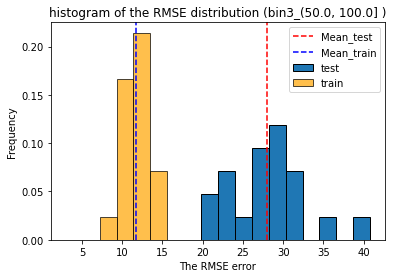

In [14]:
#RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin3, bins=np.arange(3.0,42.0,2.1), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin3, bins=np.arange(3.0,42.0,2.1), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin3_(50.0, 100.0] )')
plt.show()

In [15]:
X

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,...,VUL_StrongRoof_LightWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary
39,128.785714,7.623810,4.991964,67.297247,304783.811133,16.034037,0.61,0.00,0.00,0.00,...,5.666295,0.027878,13.639532,25.425146,0.069696,0.000000,0.006970,0.006970,2.458422,28.331475
40,137.600000,10.846970,5.338258,54.729980,163936.581742,14.053818,2.58,7.27,2.04,0.02,...,12.912221,0.072745,2.982541,24.709020,0.072745,0.048497,0.181862,0.218235,2.364638,40.058196
67,236.800000,23.022917,9.250000,68.469676,320992.456376,28.294582,5.76,1.26,1.44,0.00,...,10.650465,0.250179,5.611151,31.486776,0.321658,0.035740,0.071480,0.178699,3.152242,31.665475
79,166.710000,11.723333,6.353750,64.000391,262148.800838,20.452986,0.97,0.03,0.00,0.00,...,7.047325,0.010288,9.526749,40.843621,0.041152,0.020576,0.000000,0.010288,2.276694,30.884774
80,218.475000,20.925000,8.506771,76.858109,454013.837540,16.963048,6.14,2.50,1.14,0.00,...,18.729245,0.420633,4.250609,19.216294,0.420633,0.066416,0.088554,0.221386,1.762301,22.647775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23423,254.525000,23.410417,9.786458,47.579864,107713.362477,0.993916,0.00,0.00,0.00,0.00,...,45.496804,0.348635,0.232423,39.628123,0.232423,0.000000,0.116212,0.058106,2.409639,44.973852
23461,255.687500,21.612500,9.660417,48.218915,112112.054833,7.514910,0.00,0.00,0.00,0.00,...,14.465154,0.121556,4.821718,51.782820,0.526742,0.000000,0.121556,0.283630,7.043011,27.350081
23877,258.160000,18.825000,9.100833,49.041771,117950.133023,0.746003,0.00,0.00,0.00,0.00,...,21.207478,0.980693,2.666258,38.768005,0.796813,0.122587,0.367760,0.337113,4.078437,34.293595
23958,212.800000,15.002381,7.574107,43.430665,81919.906658,1.708735,0.00,0.00,0.00,0.00,...,29.027523,0.000000,0.880734,54.311927,0.183486,0.000000,0.073394,0.293578,5.823910,39.559633
